In [1]:
# Import Statements

# MacOS Environment
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Standard Imports
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import re

# Machine Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding, Dense, Dropout, GlobalAveragePooling1D, Input, Conv1D, MaxPooling1D, Subtract, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model


from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check Version, GPU Devices
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Tensorflow Version: 2.13.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Set Specific (Unused) GPU
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

In [4]:
# Load Datasets
dataset = 'Dataset/training.1600000.processed.noemoticon.csv'
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Read Dataset
data = pd.read_csv(dataset, encoding = 'ISO-8859-1', names = column_names)

# Displaying Head
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Clean Text Regex
def clean_text(text):

    # Remove Mentions, URL
    text = re.sub(r'(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ', text)

    # Remove Special Characters, Numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert To Lower Case
    text = text.lower().strip()

    # Return Cleaned Text
    return text

# Apply Cleaning Function To Text Column
data['clean_text'] = data['text'].apply(clean_text)

# Explore Target Column
target_counts = data['target'].value_counts()

# Display First Few Rows Of Cleaned Text, Target Distribution
clean_text_head = data[['clean_text', 'target']].head()
target_counts, clean_text_head

(target
 0    800000
 4    800000
 Name: count, dtype: int64,
                                           clean_text  target
 0  awww thats a bummer  you shoulda got david car...       0
 1  is upset that he cant update his facebook by t...       0
 2  i dived many times for the ball managed to sav...       0
 3     my whole body feels itchy and like its on fire       0
 4  no its not behaving at all im mad why am i her...       0)

In [6]:
# Check Text Lengths, Other Statistics
text_lengths = data['clean_text'].apply(lambda x: len(x.split()))
print(text_lengths.describe().apply(lambda x: '{:.1f}'.format(x)))

count    1600000.0
mean          12.4
std            6.8
min            0.0
25%            7.0
50%           11.0
75%           18.0
max           40.0
Name: clean_text, dtype: object


(array([1.20270e+05, 3.49785e+05, 3.38166e+05, 2.72388e+05, 2.19058e+05,
        1.84431e+05, 1.01516e+05, 1.40680e+04, 3.15000e+02, 3.00000e+00]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

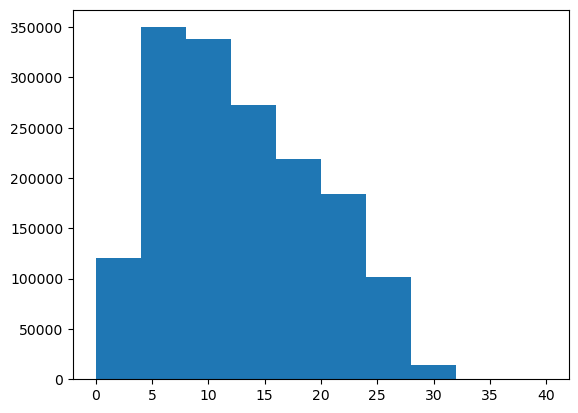

In [7]:
plt.hist(text_lengths)

There's an average of 12.4 tokens in each individual Tweet, and the Tweets follow a Gamma distribution where a right-skew exists and it's unimodal. 

In [8]:
# Encode Labels: Convert 4 -> 1 For Positive Sentiment
data['target_encoded'] = data['target'].apply(lambda x: 1 if x == 4 else 0)

# Split Data Into Features 
features = data['clean_text']
labels = data['target_encoded']

# Perform 80 / 20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# Check Shapes
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((1280000,), (320000,), (1280000,), (320000,))

In [9]:
# Setting Maximum Sequence Length
NUM_TOP_WORDS = None
MAX_ART_LEN = 180
NUM_CLASSES = 2

# Initialize, Fit Tokenizer
tokenizer = Tokenizer(num_words = NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert Text To Sequence, Padding
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(train_sequences, maxlen = MAX_ART_LEN)
X_test_padded = pad_sequences(test_sequences, maxlen = MAX_ART_LEN)

In [10]:
# Make these the variables for clarity as we proceed
X_train, X_test = X_train_padded, X_test_padded

# Ensure types are what we require
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [11]:
# Preparing GloVe Embedding
glove_file = 'Dataset/glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file, 'r', encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs

print('Found %s Word Vectors.' % len(embeddings_index))

# Create Embedding Matrix
found_words = 0
EMBED_SIZE = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

# Print Embedding Information
print("Embedding Shape:", embedding_matrix.shape,
      "\nTotal Words Found:", found_words,
      "\nPercentage:", 100 * found_words / embedding_matrix.shape[0])

# Check Shapes Of Padded Train Test Data
X_train_padded.shape, X_test_padded.shape, embedding_matrix.shape

Found 400000 Word Vectors.
Embedding Shape: (361091, 100) 
Total Words Found: 87363 
Percentage: 24.194178198847382


((1280000, 180), (320000, 180), (361091, 100))

In [12]:
COLUMN_COUNT = X_train.shape[1]

In [ ]:
# Function to plot ROC curve and calculate AUC
def plot_roc_curve(y_test, y_pred, n_classes, title):
    # Binarize the output labels for each class
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC and AUC for {title}')
    plt.legend(loc="lower right")
    plt.show()

### **2.1: 1D CNN with Higher Input Dimension and Lower Embedding Size**

2023-12-09 20:28:40.389721: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-09 20:28:40.389780: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-09 20:28:40.389791: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-09 20:28:40.389826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-09 20:28:40.389841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 180, 50)              50000     ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 176, 64)              16064     ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 35, 64)               0         ['conv1d[0][0]']              
 D)                                                                                           

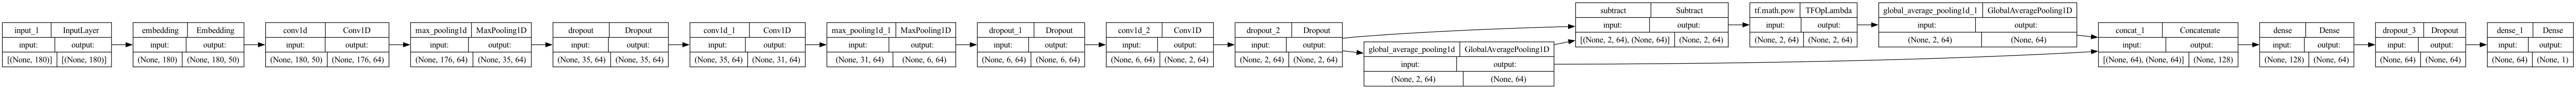

In [13]:
EMBEDDING_SIZE = 50

# Sequence input with equivale
sequence_input = Input(shape=(COLUMN_COUNT,))

embedded_sequences = Embedding(1000, # input dimension
                               EMBEDDING_SIZE, # output dimension size
                               input_length=MAX_ART_LEN)(sequence_input) # number of words in each sequence

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# extract additional features
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 95 after the conovlutions
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

cnn1 = Model(sequence_input, preds)

print(cnn1.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    cnn1, to_file='conv_model_small_embedding.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [14]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
cnn1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', Precision(), Recall(), F1Score()])

In [16]:
%%time 

history_cnn_low_embedding = []
tmp = model.fit(X_train, y_train, epochs=10, 
                batch_size=128, 
                validation_data=(X_test, y_test))
history_cnn_low_embedding.append( tmp )

Epoch 1/5


2023-12-09 20:38:50.480152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4803/10000 [=============>................] - ETA: 11:32 - loss: 0.6135 - accuracy: 0.6525 - precision: 0.6226 - recall: 0.7727 - f1_score: 0.6662

KeyboardInterrupt: 

\<TRAIN MORE EPOCHS IF NEEDED\>

In [ ]:
# History of the version of model trained for the most epochs
H1A = history_cnn_low_embedding[-1]

In [ ]:
# Plot Training Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H1A.history['accuracy'], label = 'training')

# Plot Val Accuracy
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H1A.history['val_accuracy'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(H1A.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot Val Loss
plt.plot(H1A.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = cnn1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(cnn1, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, '1st 1D CNN')

# Print the scores
print(f"Validation Scores:\n\tF1 Score: {H1A.history['val_f1score']}\n\tRecall: {H1A.history['val_recall']}")
print(f"\tPrecision: {H1A.history['val_precision']}\n\tAccuracy: {H1A.history['val_accuracy']}")

### **2.2: 1D CNN with Lower Input Dimension and Higher Embedding Size**

The difference here is that the embedding size is 200 and the input dimension to the embedding layer is 500. This means we increase the embedding size and decreased the size of the input dimension for the embedding layer. 

In [ ]:
EMBEDDING_SIZE = 200

# Sequence input with equivale
sequence_input = Input(shape=(COLUMN_COUNT,))

embedded_sequences = Embedding(500, # input dimension 
                               EMBEDDING_SIZE, # output dimension size
                               input_length=MAX_ART_LEN)(sequence_input) # number of words in each sequence

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# extract additional features
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 95 after the conovlutions
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

cnn2 = Model(sequence_input, preds)

print(cnn2.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    cnn2, to_file='conv_model_large_embedding.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
cnn2.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy', Precision(), Recall(), F1Score()])

In [ ]:
%%time 

history_cnn_high_embedding = []
tmp = cnn2.fit(X_train, y_train, epochs=10, 
                batch_size=128, 
                validation_data=(X_test, y_test))
history_cnn_high_embedding.append( tmp )

In [ ]:
# History of the version of model trained for the most epochs
H1B = history_cnn_high_embedding[-1]

In [ ]:
# Plot Training Accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H1B.history['accuracy'], label = 'training')

# Plot Val Accuracy
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H1B.history['val_accuracy'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(H1B.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot Val Loss
plt.plot(H1B.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = cnn2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(cnn1, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Second 1D CNN')

# Print the scores
print(f"Validation Scores:\n\tF1 Score: {H1B.history['val_f1score']}\n\tRecall: {H1B.history['val_recall']}")
print(f"\tPrecision: {H1B.history['val_precision']}\n\tAccuracy: {H1B.history['val_accuracy']}")

## **3: Le Transformer Oui Oui**

In [ ]:
# Save Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights = [embedding_matrix],
                            input_length = MAX_ART_LEN,
                            trainable = False)

In [ ]:
# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the sentiment labels to integers
# Using the third column (index 2) for sentiment labels
y_train = label_encoder.fit_transform(training_data.iloc[:, 2])
y_validation = label_encoder.transform(validation_data.iloc[:, 2])

# Ensure y_train and y_validation are numpy arrays
y_train = np.array(y_train)
y_validation = np.array(y_validation)


In [ ]:
# Assuming NUM_CLASSES is the number of sentiment classes
NUM_CLASSES = 2  # Replace with the actual number of sentiment classes

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(max_sequence_length,))
x = TokenAndPositionEmbedding(max_sequence_length, top_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Using softmax for multi-class classification

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

# Compiling the model
model_xformer.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
                      metrics=['accuracy', Precision(), Recall(), F1Score()])

# Training the model
history_xformer_1 = model_xformer.fit(
    X_train_padded, y_train, batch_size=64, epochs=2, 
    validation_data=(X_test, y_test)
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 280)]             0         
                                                                 
 token_and_position_embeddi  (None, 280, 32)           168960    
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_1 (Trans  (None, 280, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0   

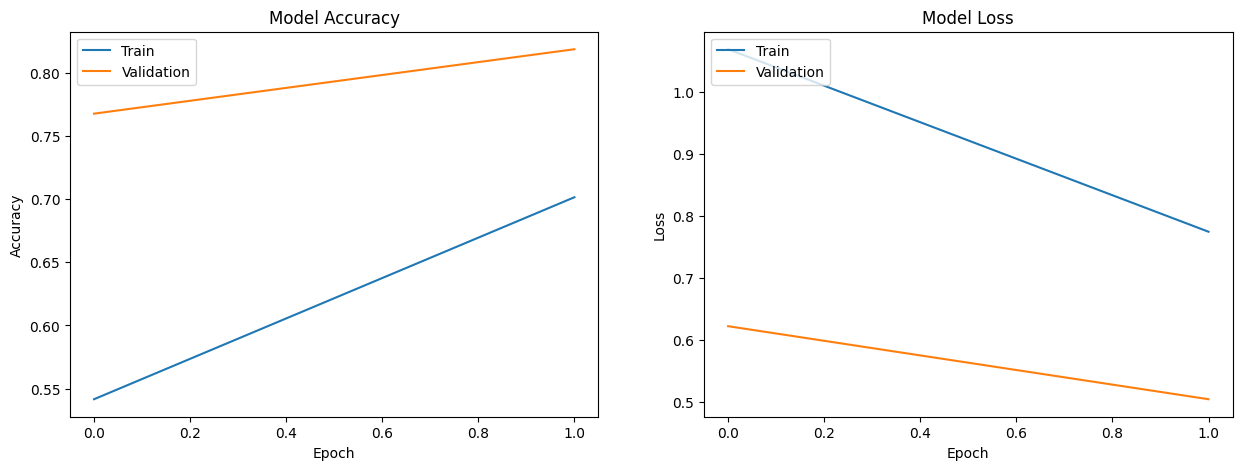

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_xformer_1.history['accuracy'])
plt.plot(history_xformer_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(122)
plt.plot(history_xformer_1.history['loss'])
plt.plot(history_xformer_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# After training, predict classes on the test set
y_pred = model_xformer.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(cnn1, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Second 1D CNN')

# Print the scores
print(f"Validation Scores:\n\tF1 Score: {history_xformer_1.history['val_f1score']}\n\tRecall: {history_xformer_1.history['val_recall']}")
print(f"\tPrecision: {history_xformer_1.history['val_precision']}\n\tAccuracy: {history_xformer_1.history['val_accuracy']}")


# **BERT Exceptional Credit**

In [ ]:
# Load Datasets
training_data_path = 'Dataset/twitter_training.csv'
validation_data_path = 'Dataset/twitter_validation.csv'
training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)
NUM_CLASSES = 3

# Combine Datasets
combined_data = pd.concat([training_data, validation_data])

# Separate Features Targets
tweets = combined_data.iloc[:, 3]
labels = combined_data.iloc[:, 2]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

In [ ]:
# Initialize WordPiece Tokenizer, Bert Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Stringify
X_train_str = X_train.astype(str).tolist()
X_test_str = X_test.astype(str).tolist()

# Tokenize
train_encodings = tokenizer(X_train_str, truncation = True, padding = 'max_length', max_length = 280, return_tensors = "tf")
test_encodings = tokenizer(X_test_str, truncation = True, padding = 'max_length', max_length = 280, return_tensors = "tf")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

ValueError: invalid literal for int() with base 10: 'Neutral'

In [ ]:
# Input Layer
input_ids = tf.keras.layers.Input(shape = (280,), dtype = tf.int32, name = "input_ids")
attention_masks = tf.keras.layers.Input(shape = (280,), dtype = tf.int32, name = "attention_masks")

# BERT Layer
bert_output = bert_model(input_ids, attention_mask=attention_masks)[1]  # We use the pooled output

# Additional layers
x = tf.keras.layers.Dense(64, activation='relu')(bert_output)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)  # num_classes is the number of your target classes

# Build the model
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_masks': train_encodings['attention_mask']},
    y_train,  # Your prepared labels
    validation_data=(
        {'input_ids': test_encodings['input_ids'], 'attention_masks': test_encodings['attention_mask']},
        y_test
    ),
    epochs=3,
    batch_size=32
)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
X_train_padded = np.array(train_encodings['input_ids'])
X_test_padded = np.array(test_encodings['input_ids'])

# You also need to convert the labels (y_train, y_test) to integer or one-hot encoding as needed